In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb
from math import factorial

## Spectral structure of a dot-product kernel under isotropic data

Given a $K(x,x') = h(\langle x, x' \rangle)$ where $h$ can be expanded in a power series $h(x) = \sum_m h_m x^m$, then the Mercer decomposition of the kernel reads:
$$
K(x,x') = \sum_m \lambda_m \sum_{|\beta| = m} He_{\beta}(x) He_{\beta}(x') 
$$
where:
$$
He_\beta(x) = \prod_{i=1}^d He_{\beta_i}(x_i)
$$

The eigenvalue are such that:
$$
\lambda_m = h_m m! \> d^{-m}
$$
provided we have normalized the trace $Tr\Sigma = 1$, hence the variances scales as $\sigma^2 = d^{-1}$. Their multeplicities is:
$$
Mol(m) = { d+m-1 \choose m}
$$
asymptotically, $Mol(m) \sim \frac{1}{m!} d^m$ with eigenvalues of order $O(d^{-m})$

Let's test these theoretical facts (empirical diagonalization)

Level 0: degeneracy = 1.0
Level 1: degeneracy = 10.0
Level 2: degeneracy = 55.0
Level 3: degeneracy = 220.0
Level 4: degeneracy = 715.0


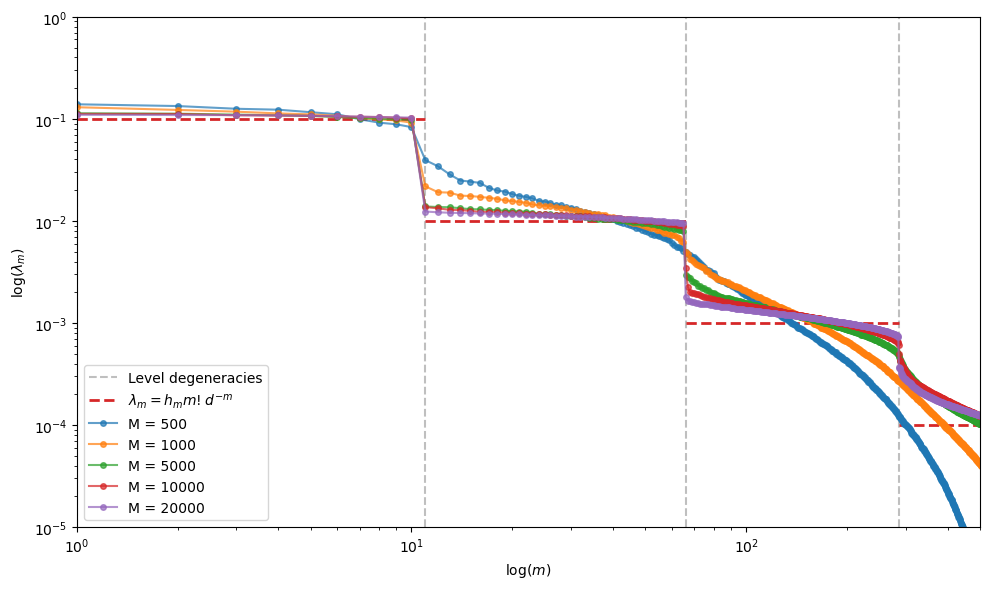

In [24]:
d = 10
def h(x):
    return np.exp(x)
taylor = [1, 1, 0.5, 1/6, 1/24] 

plt.figure(figsize=(10, 6))
# Given d, compute the degeneracies of the spectrum
coefficient = [comb(d + power - 1, power) for power in range(5)]

cumulative = 0
for i,coeff in enumerate(coefficient):
    print(f"Level {i}: degeneracy = {coeff}")
    cumulative += coeff
    plt.axvline(cumulative, color='gray', linestyle='--', alpha=0.5, label = f'Level degeneracies' if i == 0 else None)
    plt.hlines(y=pow(d, -i)*taylor[i]*factorial(i), xmin=cumulative - coeff, xmax=cumulative, color='#d62728', linestyle='--', linewidth=2, label=r'$\lambda_m = h_m m! d^{-m}$' if i == 0 else None)

#Empirical diagonalization
Ms = [500, 1000, 5000, 10000, 20000]

Sigma = np.eye(d)   # normalized covariance matrix  
Sigma *= 1/d     
for M in Ms:
    X = np.random.multivariate_normal(np.zeros(d), Sigma, M)
    Gram = X @ X.T   # This will contain the dot product between all pairs of samples
    # Now we have to apply the kernel function element-wise
    Gram = h(Gram)
    eigenvalues = np.linalg.eigvalsh(Gram)
    eigenvalues = np.sort(eigenvalues)[::-1] / M

    plt.plot(range(len(eigenvalues)), eigenvalues,  marker='o', markersize=4, alpha=0.7, label=f'M = {M}')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1, np.min(Ms))
plt.ylim(1e-5, 1)
plt.xlabel(r'$\log(m)$')
plt.ylabel(r'$\log(\lambda_m)$')
plt.legend()
plt.tight_layout()
plt.show()

Nice agreement. Hence the eigenvalues (in the isotropic case) can be resumed as:
$$
\lambda = (\lambda_0, \underbrace{\lambda_1, \dots, \lambda_1}_{g_1}, \underbrace{\lambda_2, \dots, \lambda_2}_{g_2}, ...)
$$
or
$$
\lambda = (1, \underbrace{ h_1 d^{-1}}_{d^1},  \underbrace{   2 h_2 d^{-2}}_{\frac{1}{2} d^2},  \underbrace{   6 h_3 d^{-3}}_{\frac{1}{6} d^3}, \dots)
$$
With this spectrum, we can compute analytically the generalization error. Let's start with:
$$
n - \frac{\lambda}{\nu} = Tr(\Sigma (\Sigma + \nu I)^{-1})
$$
We will make a bunch of assumptions. First of all, imagine there is no regularization constant $\lambda = 0$. Then, fix the scaling behavior of $n, d$, the sample complexity, as:
$$
n = \alpha d^\kappa
$$
where $\kappa$ is given. Now we will require that eventually $h_m = 0$ for a certain $m$ on (this is true for polynomial kernels, but we actually only need $h_m \sim 1/m!$ which is true for most functions, for example the exponential). Using the ansatz $\nu = \xi d^{-k}$
$$
\nu = d^{-k} \left(\frac{h_k}{\alpha} - h_k k! \right)
$$
Now, again, assuming a scaling $h_k \sim k!$, we'd have:
$$
\nu = -d^{-k}\left(\frac{1}{\alpha k!} - const\right)
$$
where $\exist k_0: h_k = 0, \forall k > k_0$ then $\nu = 0$ when the sample complexity is greater than $k_0$, This makes sense: when $\nu = 0$, then the bias is precisely zero, meaning that we can learn perfectly any polynomials of degree (gne, we are in the $\lambda = 0$ case remember)

Taylor coefficients: [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]


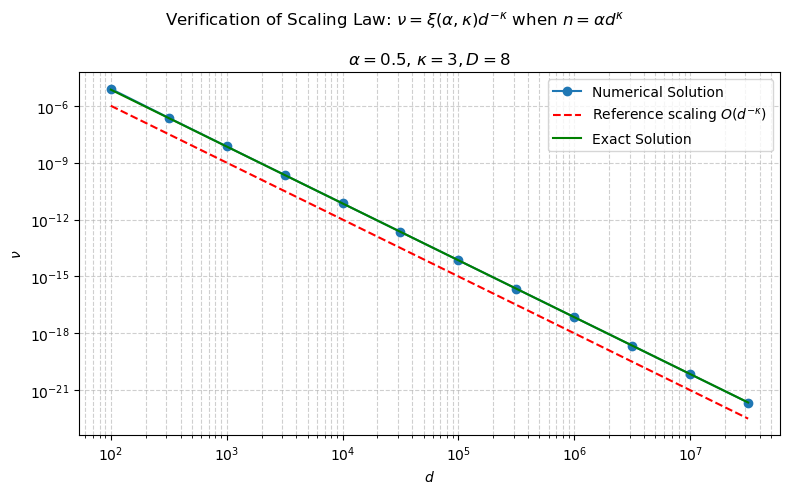

In [15]:
def get_spectrum(taylor, d, m_max=10):
    levels = []
    for m in range(m_max):
        deg = comb(d + m - 1, m)
        # Nota: per exp(x) taylor è 1/m!. L'autovalore è d^-m
        ev = pow(d, -m) * taylor[m] * factorial(m)
        levels.append((deg, ev))
    return levels

def solveNu_Newton(taylor, n, lambda_reg, d, max_iter=100, tol=1e-8):
    levels = get_spectrum(taylor, d, m_max=len(taylor))
    nu = 1.0 / n 
    
    for i in range(max_iter):
        df_val = 0
        df_deriv = 0
        
        for deg, ev in levels:
            ratio = ev / (ev + nu)
            df_val += deg * ratio
            df_deriv += deg * ( -ev / ((ev + nu)**2) )

        if lambda_reg > 0:
            F = n - (lambda_reg / nu) - df_val
            F_prime = (lambda_reg / (nu**2)) - df_deriv
        else:
            F = n - df_val
            F_prime = -df_deriv
            
        step = F / F_prime
        nu_new = nu - step
        
        if nu_new <= 0: 
            nu_new = nu * 0.5 
            
        if abs(step) < tol * nu:
            return nu_new
            
        nu = nu_new
    return nu


m_max = 50
# This is the pure power series expansion
#taylor = [1/factorial(m) for m in range(m_max)]
taylor = [1 if i < 7 else 0 for i in range(m_max)]  # D = 6
print("Taylor coefficients:", taylor[:15])
alpha = 0.5
kappa = 3

nus = []
d_range = [10**exp for exp in np.arange(2, 8, 0.5)]

for d in d_range:
    n = alpha * (d**kappa) 
    nu = solveNu_Newton(taylor, n, lambda_reg=0, d=d)
    nus.append(nu)


plt.figure(figsize=(8, 5))
plt.plot(d_range, nus, marker='o', label='Numerical Solution') 

d_values = np.array(d_range, dtype=float) 
reference = d_values**(-kappa) 

plt.plot(d_values, reference, linestyle='--', color='red', label=r'Reference scaling $O(d^{-\kappa})$')

def l(kappa, taylor):
    res = 0
    Max = len(taylor)
    for m in range(kappa+1, Max):
        res += taylor[m]/factorial(m) 
    return res


def xi(kappa, alpha, taylor):
    term = taylor[kappa] / factorial(kappa) + l(kappa, taylor) - alpha * taylor[kappa]
    xi = (1/ (2*alpha)) * (term + np.sqrt(term**2 + 4*alpha*l(kappa, taylor)*taylor[kappa]))
    return xi

derivatives = [factorial(m)*taylor[m] for m in range(m_max)]
exact_solution = [d**(-kappa)* xi(kappa, alpha, derivatives) for d in d_range ]
plt.plot(d_values, exact_solution, color='green', label=r'Exact Solution')
plt.xscale('log')
plt.yscale('log') 
plt.xlabel(r'$d$') 
plt.ylabel(r'$\nu$') 
plt.suptitle(r'Verification of Scaling Law: $\nu = \xi(\alpha, \kappa) d^{-\kappa}$ when $n = \alpha d^{\kappa}$') 
plt.title(r'$\alpha = 0.5$, $\kappa = 3, D = 8$')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.6) 
plt.tight_layout() 
plt.show()

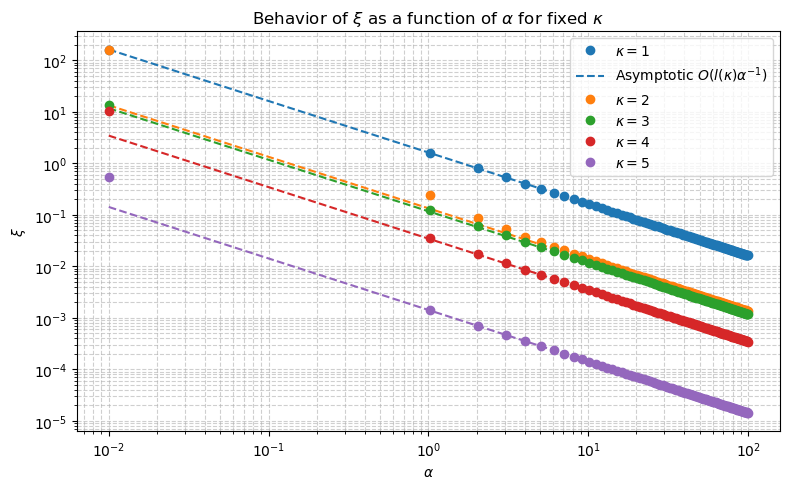

In [54]:
# What does xi look like as a function of alpha for fixed kappa?
kappas = [1,2,3,4,5]
alpha_values = np.linspace(0.01, 100, 100)
derivatives = [1,0,3,0.1,2,4,1,0.1,0.9] + [0]* (m_max - 9) # D = 9
taylor = [derivatives[m]/factorial(m) for m in range(m_max)]
plt.figure(figsize=(8, 5))

for kappa in kappas:
    xi_values = [xi(kappa, alpha, derivatives) for alpha in alpha_values]
    p = plt.plot(alpha_values, xi_values, label=r'$\kappa=' + str(kappa) + '$', marker='o', linestyle='')
    colore = p[0].get_color()
    y_teorico = alpha_values**(-1) * (l(kappa, derivatives))
    plt.plot(alpha_values, y_teorico, linestyle='--', color=colore, label=r'Asymptotic $O(l(\kappa)\alpha^{-1})$' if kappa == 1 else None)


plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\xi$')
plt.yscale('log')
plt.xscale('log')
plt.title(r'Behavior of $\xi$ as a function of $\alpha$ for fixed $\kappa$')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.tight_layout()
plt.show()

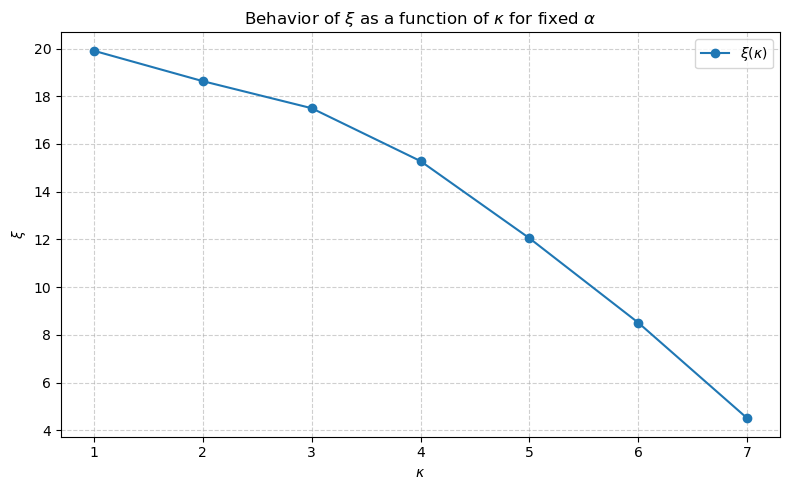

In [26]:
# What does xi look like as a function of alpha for fixed kappa?
kappa_values = [1, 2, 3, 4, 5,6,7]
alpha = 2

 
taylor = [1,2,3,0,5,6,7,8,9] + [0]* (m_max - 9) # D = 9
derivatives = [factorial(m)*taylor[m] for m in range(m_max)]
xi_values = [xi(kappa, alpha, derivatives) for kappa in kappa_values]

plt.figure(figsize=(8, 5))
plt.plot(kappa_values, xi_values, marker='o', label=r'$\xi(\kappa)$')
plt.xlabel(r'$\kappa$')
plt.ylabel(r'$\xi$')
plt.title(r'Behavior of $\xi$ as a function of $\kappa$ for fixed $\alpha$')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.tight_layout()
plt.show()

Now the variance computation:

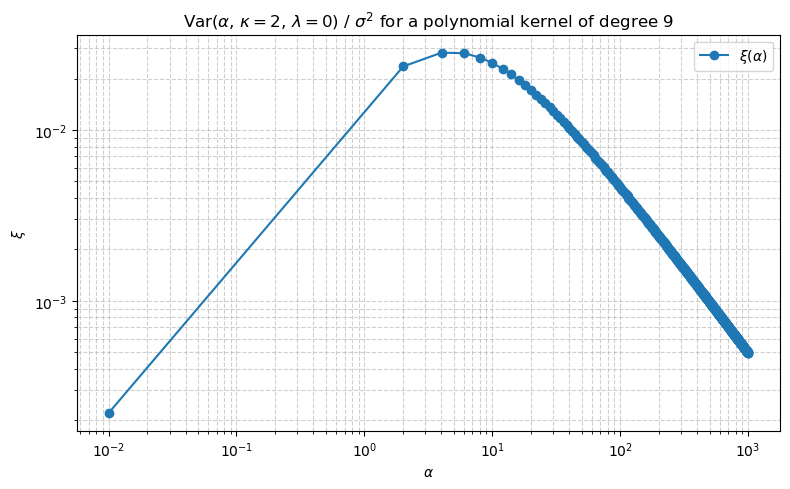

In [66]:
# What does xi look like as a function of alpha for fixed kappa?
alpha_values = np.linspace(0.01, 1000, 500)
kappa = 2

m_max = 50
derivatives = [1,0.5,0.1, 1,5,6,0.1,1,1] + [0]* (m_max - 9) # D = 9
D = 9
taylor = [derivatives[m]/factorial(m) for m in range(m_max)]

res = []
for alpha in alpha_values:
    xi_value = xi(kappa, alpha, derivatives)
    tau = ((derivatives[kappa]**2) / (derivatives[kappa] + xi_value)**2) / (alpha * factorial(kappa))
    term = tau / (1-tau)
    res.append(term)
plt.figure(figsize=(8, 5))
plt.plot(alpha_values, res, label=r'$\xi(\alpha)$', marker='o')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\xi$')
plt.xscale('log')
plt.yscale('log')

#x_ref = np.linspace(500, 10000, 500)
#y_ref = 10*x_ref**(-1)
#plt.plot(x_ref, y_ref, linestyle='--', color='red', label=r'Reference $O(\alpha^{-1})$')
plt.title(fr'Var($\alpha$, $\kappa={kappa}$, $\lambda = 0$) / $\sigma^2$ for a polynomial kernel of degree {D}')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.tight_layout()
plt.show()